1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
# from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random


df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head(12)


C:\Users\lucas\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879
6,No,Yes,919.588530,7491.558572
7,No,No,825.513331,24905.226578
8,No,Yes,808.667504,17600.451344
9,No,No,1161.057854,37468.529288
10,No,No,0.000000,29275.268293


2) Convert `default` and `student` to categorical variables.

In [3]:

def categorize(x):
    row = x.shape[0]
    data = np.zeros(row)
    for i in range(1, row+1):
        data[i-1] = x.get_value(i, "Yes")
    return data

df_default=pd.get_dummies(df['default'])
df_default=df_default.drop(['No'],1)
df_default.rename(columns={'Yes':'default'}, inplace=True)

df_student=pd.get_dummies(df['student'])
df_student=df_student.drop(['No'],1)
df_student.rename(columns={'Yes':'student'}, inplace=True)
df_final = pd.concat([df[['balance', 'income']], df_default, df_student],axis=1 )

df_final.head(10)

,balance,income,default,student
1,729.526495,44361.625074,0.0,0.0
2,817.180407,12106.134700,0.0,1.0
3,1073.549164,31767.138947,0.0,0.0
4,529.250605,35704.493935,0.0,0.0
5,785.655883,38463.495879,0.0,0.0
6,919.588530,7491.558572,0.0,1.0
7,825.513331,24905.226578,0.0,0.0
8,808.667504,17600.451344,0.0,1.0
9,1161.057854,37468.529288,0.0,0.0
10,0.000000,29275.268293,0.0,0.0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


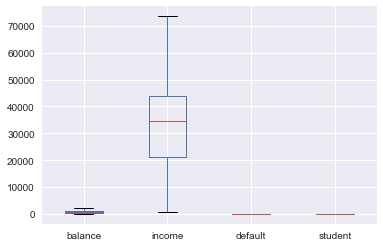

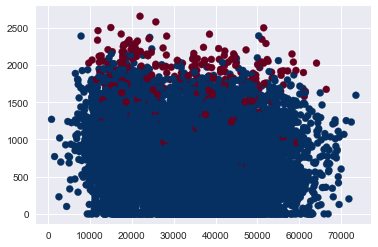

In [4]:
df_final.boxplot()
plt.show()
# print(type(df_final['income']))
x = np.array(df_final['income'], dtype=pd.Series)
y = np.array(df_final['balance'], dtype=pd.Series)
plt.scatter(x = df_final.income,y = df_final.balance, c = df_final.default, cmap=plt.cm.RdBu_r)
# Still need to check if default corresponds to red or blue
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

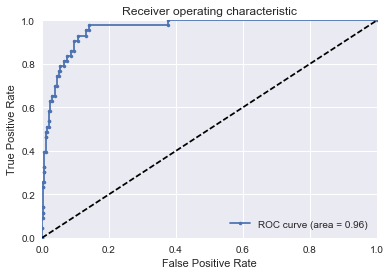

In [6]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
#     print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
    
# X are features and y is predictive variable - cancelled HD or not.
X = df_final.drop(['student', 'default'], 1) #take out the student feature
y = df_final['default']

# Scale columns for regression.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# n_samples, n_features = X.shape

# # Split the data
# half = int(n_samples/2)
# X_train, X_test = X[:half], X[half:]
# y_train, y_test = y[:half], y[half:]

# # Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    #     regr = LogisticRegression(C=alpha,penalty='l1')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
# plt.plot(alphas,scores)
# plt.show()

alpha_best = alphas[np.argmax(scores)]

# Generate ROC  for LR with l1 penalty and C=alpha_best
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=alpha_best)
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

### Now we plot the decision boundary onto the scatter plot

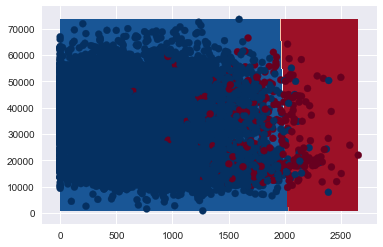

In [7]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# X are features and y is predictive variable - cancelled HD or not.
X = df_final.drop(['student', 'default'], 1)
y = df_final['default']

X_data = np.array(X, dtype=pd.Series)
y_data = np.array(y, dtype=pd.Series)

h = 10
clf1 = LogisticRegression(C=alpha_best,penalty='l1') #DecisionTreeClassifier(max_depth=2)
clf1.fit(X, y)

x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
# print(Z)
plt.contourf(xx, yy,Z, cmap=plt.cm.RdBu_r)


# Plot also the training points
plt.scatter(X_data[:, 0], X_data[:, 1], c=y, cmap=plt.cm.RdBu_r)



5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

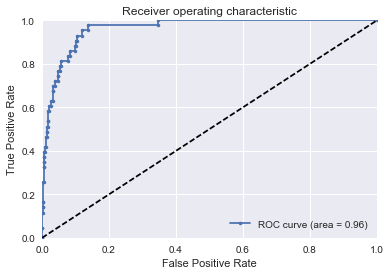

In [8]:
# X are features and y is predictive variable - cancelled HD or not.
X = df_final.drop(['default'], 1)
y = df_final['default']

# Scale columns for regression.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# n_samples, n_features = X.shape

# # # Split the data
# # half = int(n_samples/2)
# # X_train, X_test = X[:half], X[half:]
# # y_train, y_test = y[:half], y[half:]

scores = []
for alpha in alphas:

    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)

alpha_best = alphas[np.argmax(scores)]

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=alpha_best)
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


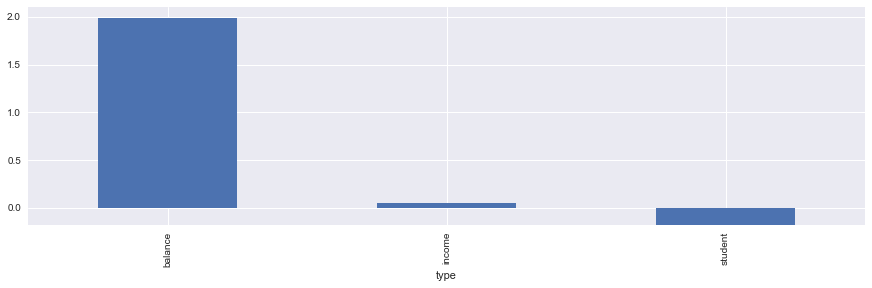

In [9]:
regr = LogisticRegression(C=alpha_best,penalty='l2')
df_data = df_final.drop(['default'], 1)

# Train the model using the training sets

regr.fit(X, y)

dfCoeffs = pd.DataFrame({'type':df_data.columns.values, 'coef':regr.coef_[0]})

df_reduced = dfCoeffs[(dfCoeffs['coef']>0) | (dfCoeffs['coef']<0)]
plt.figure(figsize=(15,4))
dfCoeffs2 = df_reduced.groupby('type')['coef'].mean()
dfCoeffs2.sort()
dfCoeffs2[::-1].plot(kind='bar')

## The area remains at 0.96, which means the includsion of student feature doesn't have important influence in the 

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

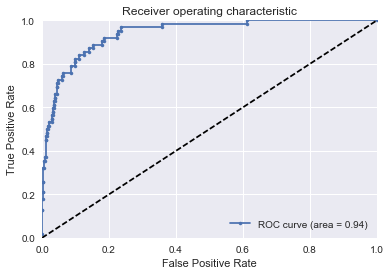

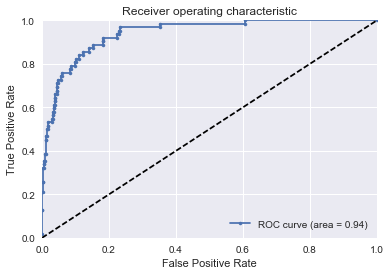

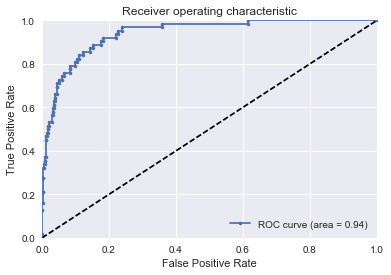

In [12]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing

# X are features and y is predictive variable - cancelled HD or not.
X = df_final.drop(['default'], 1)
y = df_final['default']


#Randomized
from sklearn.utils import shuffle

for s in range(3):
    random_state = np.random.RandomState(0)
    X_random, y_random = shuffle(X, y, random_state=random_state)
    fpr,tpr,roc_auc, thresholds = generate_auc(X_random,y_random,LogisticRegression,C=alpha_best, penalty='l1')
    generate_ROCplot(fpr,tpr,'LR',roc_auc)
    

## The areas for different random states remain relatively stable, which menas the logistic regression model we used is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus 
import pydot
import graphviz

from sklearn import tree
from os import system

import subprocess
%matplotlib inline

X = df_final.drop(['default'], 1)
y = df_final['default']
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dt.fit(X, y)
features = X.columns
# dotfile = open("D:/dtree2.dot", 'w')
# tree.export_graphviz(dt, out_file = dotfile, feature_names = X.columns)
# dotfile.close()
# system("dot -Tpng D:.dot -o D:/dtree2.png")

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
visualize_tree(dt, features)


In [ ]:
X = df_final[['balance', 'income']]
y = df_final.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(criterion='entropy',  max_depth=5)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='tree.dot')

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph, format='png')

8) Find the optimal decision tree depth and compute the AUC ROC. 

In [ ]:
scores = []
depths = np.arange(1, 5)
for depth in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=depth)
    scores.append(roc_auc)
# plt.plot(alphas,scores)

best_depth = depths[np.argmax(scores)]
print("best_depth is", best_depth)
# Generate ROC  for LR with l1 penalty and C=alpha_best
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=best_depth)
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)